<a href="https://colab.research.google.com/github/pahul1712/Sentiement_Analysis_for_IMDB_Dataset/blob/main/Sentiment_Analysis_for_IMDB_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U transformers
!pip install -U accelerate
!pip install -U datasets
!pip install -U bertviz
!pip install -U umap-learn

In [2]:
import torch

if torch.cuda.is_available():
       device = torch.device("cuda")
       print("GPU is available and being used.")
else:
       device = torch.device("cpu")
       print("GPU not available, usingÂ CPUÂ instead.")

GPU is available and being used.


In [3]:
!pip install spacy
!pip install -m spacy download en_core_web_sm
!pip install beautifulsoup4
!pip install textblob
!pio install mlxtend
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -m
/bin/bash: line 1: pio: command not found
  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to /tmp/pip-req-build-cnfo0cfy
  Running command git clone --filter=blob:none --quiet https://github.com/laxmimerit/preprocess_kgptalkie.git /tmp/pip-req-build-cnfo0cfy
  Resolved https://github.com/laxmimerit/preprocess_kgptalkie.git to commit 0f56a6502679f6750b7f0ffed98f590d1f0246bd
  Preparing metadata (setup.py) ... done
  Created wheel for preprocess_kgptalkie: filename=preprocess_kgptalkie-0.11-py3-none-any.whl size=8175 sha256=ff22af4a8f6f3266c8da889fc9f236235ce521dcf81348ce238eeaa18a9d0935
  Stored in directory: /tmp/pip-ephem-wheel-cache-z

In [4]:
# Sentiment Analysis with the pipeline

from transformers import pipeline

sentiment_pipeline = pipeline("sentiment-analysis")

data = ["I love you", "I hate you"]
sentiment_pipeline(data)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use cuda:0


[{'label': 'POSITIVE', 'score': 0.9998656511306763},
 {'label': 'NEGATIVE', 'score': 0.9991129040718079}]

## Data Loading and Preprocessing

In [5]:
!pip install -U googletrans==4.0.0-rc1

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import preprocess_kgptalkie as ps

In [7]:
df =pd.read_csv("https://github.com/laxmimerit/All-CSV-ML-Data-Files-Download/raw/refs/heads/master/IMDB-Dataset.csv")
df = df.sample(10000)
df.head()

review sentiment
46863  "The Incredible Melting Man" is a fantasticall...  positive
26280  There was not one original idea in this story....  negative
17028  This movie blew me away - I have only seen two...  positive
38079  I found this to be a tremendously disappointin...  negative
2538   Horrible. I see many user comments on how grea...  negative

In [8]:
df.head()

review sentiment
46863  "The Incredible Melting Man" is a fantasticall...  positive
26280  There was not one original idea in this story....  negative
17028  This movie blew me away - I have only seen two...  positive
38079  I found this to be a tremendously disappointin...  negative
2538   Horrible. I see many user comments on how grea...  negative

In [9]:
df.shape

(10000, 2)

In [10]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

## **Data Preprocessing**

In [11]:
df['word_counts'] = df['review'].apply(lambda x: ps.word_count(x))
df['char_counts'] = df['review'].apply(lambda x: ps.char_count(x))
df['avb_wordlength'] = df['review'].apply(lambda x: ps.avg_word_len(x))
df['stopwords_counts'] = df['review'].apply(lambda x: ps.stop_words_count(x))

In [12]:
df.head()

review sentiment  \
46863  "The Incredible Melting Man" is a fantasticall...  positive   
26280  There was not one original idea in this story....  negative   
17028  This movie blew me away - I have only seen two...  positive   
38079  I found this to be a tremendously disappointin...  negative   
2538   Horrible. I see many user comments on how grea...  negative   

       word_counts  char_counts  avb_wordlength  stopwords_counts  
46863          246         1227        4.987805               104  
26280          130          618        4.753846                67  
17028          358         1568        4.379888               194  
38079          129          614        4.759690                59  
2538           122          570        4.672131                67

In [13]:
df['review'] = df['review'].str.lower()

In [14]:
df['review'] = df['review'].apply(lambda x: ps.remove_html_tags(x))

/usr/local/lib/python3.11/dist-packages/preprocess_kgptalkie/text_preprocess.py:92: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(x, 'lxml').get_text()


<Axes: >

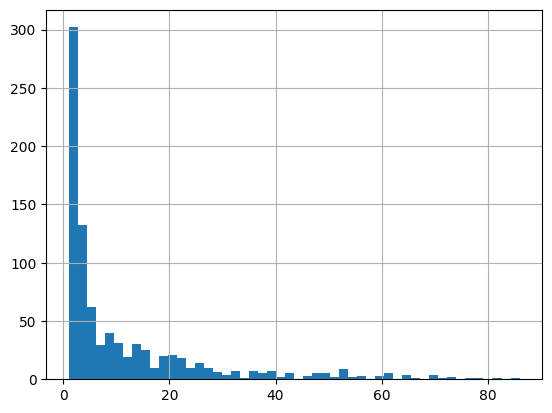

In [15]:
df['word_counts'].value_counts().hist(bins =50)

## Data Preparation for ML

In [16]:
# custom dataset -> evaluation/compute metrics -> training arguments -> trainer -> training -> testing

In [17]:
import torch
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

In [18]:
class CustomDataset(Dataset):
  def __init__(self, texts, labels, tokenizer, max_len=512):
    self.texts = texts
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = str(self.texts[idx])
    label = torch.tensor(self.labels[idx])

    encoding = self.tokenizer(text, truncation=True, padding = "max_length",
                          max_length = self.max_len)

    return {
          'input_ids': encoding['input_ids'],
          'attention_mask': encoding['attention_mask'],
          'labels': label
      }

In [19]:
# prepare tokenizer and model
from transformers import AutoTokenizer, AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased"
device = "cuda"

tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2).to(device)




Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [21]:
X = df['review'].tolist()

label2id = {'negative': 0, 'positive': 1}
id2label = {0: 'negative', 1: 'positive'}

y = df['sentiment'].map(label2id).tolist()

dataset = CustomDataset(X, y, tokenizer)

In [22]:
dataset[0].keys()

dict_keys(['input_ids', 'attention_mask', 'labels'])

In [23]:
train_dataset , test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

In [24]:
from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(example):
  labels = example.label_ids
  preds = example.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

In [25]:
from transformers import TrainingArguments, Trainer

batch_size  = 16
model_name  = "distilbert_finetuned_sentiment"

args = TrainingArguments(
    output_dir = "output",
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    learning_rate = 2e-5,
    num_train_epochs = 1,
    evaluation_strategy = "epoch"
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of ðŸ¤— Transformers. Use `eval_strategy` instead
  warnings.warn(


In [26]:
trainer = Trainer(
    model = model,
    args = args,
    train_dataset = train_dataset,
    eval_dataset = test_dataset,
    compute_metrics = compute_metrics,
    tokenizer = tokenizer
)

<ipython-input-26-457edd1bc615>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [27]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: pahuldeepsingh531 (pahuldeepsingh531-florida-atlantic-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


TrainOutput(global_step=500, training_loss=0.3071693115234375, metrics={'train_runtime': 423.6595, 'train_samples_per_second': 18.883, 'train_steps_per_second': 1.18, 'total_flos': 1059739189248000.0, 'train_loss': 0.3071693115234375, 'epoch': 1.0})

In [28]:
trainer.save_model(model_name)

In [30]:
text = "I love this product"

pipe  = pipeline("text-classification", model=model_name)
pipe(text)

Device set to use cuda:0


[{'label': 'LABEL_1', 'score': 0.9561828970909119}]

In [31]:
id2label

{0: 'negative', 1: 'positive'}

In [34]:
text = "I love this product"

tok  = AutoTokenizer.from_pretrained(model_name)
mod  = AutoModelForSequenceClassification.from_pretrained(model_name)

In [38]:
def get_prediction(text):
  input_ids = tok.encode(text, return_tensors="pt")

  output  = mod(input_ids)

  preds = torch.nn.functional.softmax(output.logits, dim=-1)
  preds

  prob  =torch.max(preds).item()


  idx = torch.argmax(preds).item()

  sentiment  = id2label[idx]

  return {'sentiment' : sentiment, 'prob' : prob}

In [41]:
text =  "I don't the exact usecase of this product but I still like it"

get_prediction(text)

{'sentiment': 'positive', 'prob': 0.8878034353256226}